# Download the CelebA dataset

In [ ]:
# For colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import requests
import tarfile
from tqdm import tqdm
import time
import gdown

In [ ]:
def download_celeb_a(dirpath):
    # dirpath = '/content/drive/MyDrive/TA/LG_DS_2022_TEST/0224_test/D9.1/data'
    data_dir = 'celebA'
    
    if os.path.exists(os.path.join(dirpath, data_dir)):
        print('Found Celeb-A - skip')
        return
    
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
    _url = "https://drive.google.com/uc?id=1-8IZuZh0_f7q-v68yx4pzJtXoWpy81N1&confirm=t"
    filename  = "celebA.tgz" 
    save_path = os.path.join(dirpath, filename)

    if os.path.exists(save_path):
        print('[*] {} already exists'.format(save_path))
    else:
        gdown.download(_url, save_path)
    
    print("Start extracting tar file.")
    with tarfile.open(save_path) as open_tarfile:
        open_tarfile.extractall(dirpath)        
    os.remove(save_path)
    print("Download CelebA End.")


In [ ]:
dirpath = './data'
download_celeb_a(dirpath)

Downloading...
From: https://drive.google.com/uc?id=1-8IZuZh0_f7q-v68yx4pzJtXoWpy81N1&confirm=t
To: /content/drive/MyDrive/TA/LG_DS_2022_TEST/0224_test/D9.1/data/celebA.tgz
100%|██████████| 1.29G/1.29G [00:09<00:00, 131MB/s]


Start extracting tar file.
Download CelebA End.


# Preprocess the CelebA dataset and Batch them

In [ ]:
%matplotlib inline
import os
import math
import numpy as np

from glob import glob
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
# Image configuration
import random

IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
data_files = glob(os.path.join(dirpath, 'celebA/*.jpg')) # list of all '.jpg' files
data_shape = (len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [ ]:
def get_image(image_path, width, height, mode):
    """
    Read an image from image_path, and crop/resize the image
    """
    image = Image.open(image_path)
    
    if image.size != (width, height):
        # Remove pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

In [ ]:
def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single batch
    """
    data_batch = np.array(
        [get_image(sample_file, width, height, mode)
         for sample_file in image_files]).astype(np.float32)
    
    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))
        
    return data_batch

In [ ]:
def get_batches(batch_size, data_files, data_shape):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255
    
    cur_index = 0
    while cur_index + batch_size <= data_shape[0]:
        # print(f"This batch: [{cur_index}/{data_shape[0]}]")
        data_batch = get_batch(data_files[cur_index:cur_index + batch_size], 
                               *data_shape[1:3])
        cur_index += batch_size
        yield data_batch / IMAGE_MAX_VALUE - 0.5

In [ ]:
def images_square_grid(images, mode='RGB'):
    """
    Helper function to save images as a square grid (visualization)
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))
    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))
    return new_im

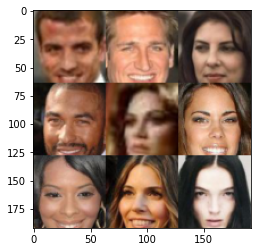

In [ ]:
test_images = get_batch(glob(os.path.join(dirpath, 'celebA/*.jpg'))[:10], data_shape[1], data_shape[2])
plt.imshow(images_square_grid(test_images))

# Discriminator network

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input
import tensorflow.keras.layers as ly

In [ ]:
def get_discriminator():
    D = tf.keras.Sequential()
    
    D.add(Input(shape=(64,64,3)))

    # Conv1
    D.add(ly.Conv2D(filters=64, kernel_size=5, strides=2, padding='same'))
    D.add(ly.LeakyReLU())

    # Conv2
    D.add(ly.Conv2D(filters=128, kernel_size=5, strides=2, padding='same'))
    D.add(ly.BatchNormalization())
    D.add(ly.LeakyReLU())

    # Conv3
    D.add(ly.Conv2D(filters=256, kernel_size=5, strides=1, padding='same'))
    D.add(ly.BatchNormalization())
    D.add(ly.LeakyReLU())

    # Flatten
    D.add(ly.Reshape(target_shape=(16*16*256,))) # Don't consider the batch size 
    D.add(ly.Dense(units=1))
    return D

# Generator network

In [ ]:
def get_generator(z_dim, out_channel_dim):
    generator = tf.keras.Sequential()

    # Fully connected layer
    generator.add(Input(shape=(z_dim,)))
    generator.add(ly.Dense(units=2*2*512))

    # Reshape
    generator.add(ly.Reshape(target_shape=(2, 2, 512))) # Don't consider the batch size
    generator.add(ly.BatchNormalization())
    generator.add(ly.LeakyReLU(alpha=0.2))

    # Deconv 1
    generator.add(ly.Conv2DTranspose(filters=256, kernel_size=5, strides=3, padding="VALID"))
    generator.add(ly.BatchNormalization())
    generator.add(ly.LeakyReLU(alpha=0.2))

    # Deconv 2
    generator.add(ly.Conv2DTranspose(filters=128, kernel_size=5, strides=4, padding="same"))
    generator.add(ly.BatchNormalization())
    generator.add(ly.LeakyReLU(alpha=0.2))

    # Output layer
    generator.add(ly.Conv2DTranspose(filters=out_channel_dim, kernel_size=5, strides=2, padding="same"))
    generator.add(ly.Activation('tanh'))
    return generator

# Loss functions

In [ ]:
def discriminator_loss(real_output, fake_output, label_smoothing=0.9):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = bce(tf.ones_like(real_output) * label_smoothing, real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output, label_smoothing=0.9):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return bce(tf.ones_like(fake_output) * label_smoothing, fake_output)

# Parameter optimization

In [ ]:
def train_step(images, batch_size, z_dim, G, D, gen_opt, disc_opt):
    noise = tf.random.normal([batch_size, z_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_tape.watch(G.trainable_variables)
        disc_tape.watch(D.trainable_variables)
        
        generated_images = G(noise, training=True)
        
        real_output = D(images, training=True)
        fake_output = D(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, D.trainable_variables)
    
    gen_opt.apply_gradients(zip(gradients_of_generator, G.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))
    return gen_loss, disc_loss

In [ ]:
def train(data_files, epochs, batch_size, z_dim, data_shape, 
         G, D, gen_opt, disc_opt):
    seed = tf.random.normal([1, z_dim])
    save_images(G, step=0, test_input_noise=seed)
    step=0
    for epoch in range(1, epochs+1):
        start = time.time()
        for batch_images in tqdm(get_batches(batch_size, data_files, data_shape)):
            gen_loss, disc_loss = train_step(batch_images, batch_size, z_dim, G, D,
                                            gen_opt, disc_opt)
            
            step += 1
            if step % 400 == 0:
                save_images(G,step,seed)                
                print(f'{step:6d} Gen loss: {gen_loss:.4f}, Disc loss: {disc_loss:.4f}')
#             if step == 2000:
#                 break
                
    # Save image after training
    save_images(G,step,seed)

In [ ]:
def save_images(model, step, test_input_noise):
    predictions = model(test_input_noise, training=False)
    img_pth = './gen_images'
    if not os.isdir(img_pth):
        os.mkdir(img_pth)
    img_name = f'{img_pth}/{step}.png'
    for i in range(predictions.shape[0]):
        tf.keras.preprocessing.image.save_img(img_name, predictions[i])

In [ ]:
max_epoch = 10
z_dim = 100
batch_size = 16
beta1 = 0.5

gen_opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=beta1)
disc_opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=beta1)

G = get_generator(z_dim, data_shape[3])
D = get_discriminator()
train(data_files, max_epoch, batch_size, z_dim, data_shape,
     G, D, gen_opt, disc_opt)

401it [01:10,  5.71it/s]

   400 Gen loss: 3.8254, Disc loss: 0.6268


800it [02:20,  5.96it/s]

   800 Gen loss: 5.2394, Disc loss: 0.4325


1201it [03:30,  5.52it/s]

  1200 Gen loss: 8.4137, Disc loss: 0.4437


1601it [04:40,  5.24it/s]

  1600 Gen loss: 9.8592, Disc loss: 0.4352


2001it [05:49,  5.63it/s]

  2000 Gen loss: 3.3140, Disc loss: 0.4178


2401it [06:59,  5.77it/s]

  2400 Gen loss: 2.5087, Disc loss: 0.6123


2801it [08:08,  5.37it/s]

  2800 Gen loss: 2.1957, Disc loss: 0.6567


3201it [09:18,  5.23it/s]

  3200 Gen loss: 1.3475, Disc loss: 0.8339


3601it [10:28,  5.65it/s]

  3600 Gen loss: 5.2562, Disc loss: 0.5977


4001it [11:37,  5.28it/s]

  4000 Gen loss: 1.2444, Disc loss: 0.9373


4401it [12:46,  5.73it/s]

  4400 Gen loss: 6.9719, Disc loss: 1.3762


4800it [13:55,  5.82it/s]

  4800 Gen loss: 6.6748, Disc loss: 2.5155


5201it [15:04,  5.57it/s]

  5200 Gen loss: 4.5147, Disc loss: 0.4478


5601it [16:13,  5.52it/s]

  5600 Gen loss: 3.1347, Disc loss: 0.5700


6001it [17:23,  5.61it/s]

  6000 Gen loss: 1.9879, Disc loss: 0.6625


6401it [18:31,  6.03it/s]

  6400 Gen loss: 1.2041, Disc loss: 1.0263


6801it [19:41,  5.95it/s]

  6800 Gen loss: 3.8067, Disc loss: 0.4806


7201it [20:50,  5.48it/s]

  7200 Gen loss: 2.4143, Disc loss: 0.5588


7601it [22:00,  6.01it/s]

  7600 Gen loss: 4.8804, Disc loss: 0.4251


8001it [23:10,  5.77it/s]

  8000 Gen loss: 1.8468, Disc loss: 0.7621


8401it [24:19,  5.76it/s]

  8400 Gen loss: 5.7589, Disc loss: 1.0999


8801it [25:28,  5.32it/s]

  8800 Gen loss: 2.2964, Disc loss: 0.5628


9201it [26:38,  5.83it/s]

  9200 Gen loss: 1.9981, Disc loss: 0.5111


9601it [27:47,  5.77it/s]

  9600 Gen loss: 4.0492, Disc loss: 0.5569


10001it [28:55,  5.47it/s]

 10000 Gen loss: 4.1981, Disc loss: 0.4248


10401it [30:04,  5.37it/s]

 10400 Gen loss: 1.8579, Disc loss: 0.7070


10801it [31:12,  5.69it/s]

 10800 Gen loss: 5.5357, Disc loss: 0.4020


11201it [32:21,  5.73it/s]

 11200 Gen loss: 1.9110, Disc loss: 0.7393


11601it [33:30,  6.15it/s]

 11600 Gen loss: 2.8464, Disc loss: 0.5895


12001it [34:39,  5.56it/s]

 12000 Gen loss: 3.1595, Disc loss: 0.6092


12401it [35:48,  5.73it/s]

 12400 Gen loss: 2.8339, Disc loss: 0.5418


12662it [36:33,  5.77it/s]
139it [00:22,  5.69it/s]

 12800 Gen loss: 4.0249, Disc loss: 0.4589


539it [01:29,  6.17it/s]

 13200 Gen loss: 3.1883, Disc loss: 0.4998


939it [02:37,  5.85it/s]

 13600 Gen loss: 1.8869, Disc loss: 0.8873


1339it [03:45,  5.68it/s]

 14000 Gen loss: 4.3323, Disc loss: 0.4338


1739it [04:52,  5.61it/s]

 14400 Gen loss: 3.6821, Disc loss: 0.7744


2139it [05:59,  6.23it/s]

 14800 Gen loss: 1.7233, Disc loss: 0.7535


2539it [07:07,  5.91it/s]

 15200 Gen loss: 3.1397, Disc loss: 0.8602


2939it [08:16,  5.63it/s]

 15600 Gen loss: 2.6187, Disc loss: 0.4245


3339it [09:23,  6.15it/s]

 16000 Gen loss: 2.4909, Disc loss: 0.5899


3739it [10:31,  5.77it/s]

 16400 Gen loss: 0.7813, Disc loss: 2.1233


4139it [11:39,  5.54it/s]

 16800 Gen loss: 2.7204, Disc loss: 0.5575


4539it [12:46,  5.55it/s]

 17200 Gen loss: 2.3284, Disc loss: 0.5933


4939it [13:53,  5.72it/s]

 17600 Gen loss: 2.6480, Disc loss: 0.6195


5339it [15:00,  5.97it/s]

 18000 Gen loss: 3.3775, Disc loss: 0.5737


5739it [16:08,  5.96it/s]

 18400 Gen loss: 5.5179, Disc loss: 1.1057


6139it [17:16,  5.46it/s]

 18800 Gen loss: 2.8631, Disc loss: 0.4846


6539it [18:23,  5.39it/s]

 19200 Gen loss: 2.9245, Disc loss: 0.7498


6939it [19:31,  5.69it/s]

 19600 Gen loss: 3.0068, Disc loss: 0.5241


7339it [20:38,  5.92it/s]

 20000 Gen loss: 3.0625, Disc loss: 0.4505


7739it [21:46,  6.39it/s]

 20400 Gen loss: 0.8494, Disc loss: 1.2402


8139it [22:53,  5.58it/s]

 20800 Gen loss: 1.8403, Disc loss: 0.6353


8539it [24:00,  5.80it/s]

 21200 Gen loss: 3.0464, Disc loss: 0.5509


8939it [25:08,  5.71it/s]

 21600 Gen loss: 3.4759, Disc loss: 0.6841


9339it [26:16,  5.74it/s]

 22000 Gen loss: 3.1065, Disc loss: 1.7631


9739it [27:24,  5.62it/s]

 22400 Gen loss: 3.4861, Disc loss: 0.7636


10139it [28:31,  6.26it/s]

 22800 Gen loss: 3.4373, Disc loss: 0.7289


10539it [29:38,  5.51it/s]

 23200 Gen loss: 2.5688, Disc loss: 0.6933


10939it [30:45,  5.80it/s]

 23600 Gen loss: 0.7926, Disc loss: 1.7507


11339it [31:54,  5.38it/s]

 24000 Gen loss: 1.9281, Disc loss: 0.5943


11739it [33:02,  5.65it/s]

 24400 Gen loss: 2.6054, Disc loss: 0.4898


12139it [34:10,  5.60it/s]

 24800 Gen loss: 3.4392, Disc loss: 0.4164


12539it [35:17,  5.89it/s]

 25200 Gen loss: 1.9653, Disc loss: 0.7689


12662it [35:38,  5.92it/s]
277it [00:39,  6.30it/s]

 25600 Gen loss: 1.3686, Disc loss: 0.8736


677it [01:35,  6.71it/s]

 26000 Gen loss: 1.7429, Disc loss: 0.8826


1077it [02:32,  7.19it/s]

 26400 Gen loss: 3.5604, Disc loss: 0.7118


1477it [03:28,  6.76it/s]

 26800 Gen loss: 2.2085, Disc loss: 0.6629


1877it [04:26,  6.49it/s]

 27200 Gen loss: 2.3951, Disc loss: 0.5940


2277it [05:24,  6.87it/s]

 27600 Gen loss: 4.2906, Disc loss: 0.6352


2677it [06:20,  6.27it/s]

 28000 Gen loss: 1.6467, Disc loss: 0.6574


3077it [07:18,  6.00it/s]

 28400 Gen loss: 1.4654, Disc loss: 0.9063


3477it [08:17,  6.89it/s]

 28800 Gen loss: 2.8133, Disc loss: 0.6426


3877it [09:13,  6.72it/s]

 29200 Gen loss: 5.6819, Disc loss: 0.7531


4277it [10:11,  7.36it/s]

 29600 Gen loss: 5.2782, Disc loss: 1.2775


4677it [11:10,  6.25it/s]

 30000 Gen loss: 3.0847, Disc loss: 0.5665


5077it [12:07,  7.73it/s]

 30400 Gen loss: 2.8681, Disc loss: 0.8369


5477it [13:04,  6.62it/s]

 30800 Gen loss: 2.4081, Disc loss: 0.8814


5877it [14:02,  6.20it/s]

 31200 Gen loss: 0.9219, Disc loss: 1.1672


6277it [15:03,  6.56it/s]

 31600 Gen loss: 4.6523, Disc loss: 0.6703


6677it [16:01,  6.51it/s]

 32000 Gen loss: 3.4089, Disc loss: 0.5197


7077it [16:58,  6.41it/s]

 32400 Gen loss: 3.5168, Disc loss: 1.4274


7477it [17:56,  5.74it/s]

 32800 Gen loss: 3.2605, Disc loss: 0.9522


7877it [18:54,  6.88it/s]

 33200 Gen loss: 3.2806, Disc loss: 0.4878


8277it [19:50,  8.18it/s]

 33600 Gen loss: 0.8097, Disc loss: 1.3008


8677it [20:47,  6.09it/s]

 34000 Gen loss: 4.1404, Disc loss: 0.4351


9077it [21:45,  5.99it/s]

 34400 Gen loss: 2.8051, Disc loss: 0.8237


9477it [22:44,  6.24it/s]

 34800 Gen loss: 3.1877, Disc loss: 0.9866


9877it [23:42,  6.79it/s]

 35200 Gen loss: 2.0607, Disc loss: 0.7035


10277it [24:40,  6.63it/s]

 35600 Gen loss: 2.4142, Disc loss: 0.7735


10677it [25:35,  6.42it/s]

 36000 Gen loss: 3.4502, Disc loss: 0.8104


11077it [26:34,  7.06it/s]

 36400 Gen loss: 2.6031, Disc loss: 0.6644


11477it [27:32,  6.84it/s]

 36800 Gen loss: 2.2315, Disc loss: 0.7876


11877it [28:30,  6.17it/s]

 37200 Gen loss: 3.0340, Disc loss: 1.5362


12277it [29:28,  6.59it/s]

 37600 Gen loss: 2.8004, Disc loss: 0.4784


12662it [30:24,  6.94it/s]
15it [00:02,  7.10it/s]

 38000 Gen loss: 1.0922, Disc loss: 1.0529


415it [01:00,  6.23it/s]

 38400 Gen loss: 3.8866, Disc loss: 1.0890


815it [01:57,  6.75it/s]

 38800 Gen loss: 2.2722, Disc loss: 0.5516


1215it [02:55,  6.32it/s]

 39200 Gen loss: 1.5902, Disc loss: 0.8826


1615it [03:51,  7.33it/s]

 39600 Gen loss: 0.8165, Disc loss: 1.0591


2015it [04:48,  6.69it/s]

 40000 Gen loss: 2.2248, Disc loss: 0.9521


2415it [05:45,  6.47it/s]

 40400 Gen loss: 2.4867, Disc loss: 0.4996


2815it [06:42,  6.51it/s]

 40800 Gen loss: 1.4970, Disc loss: 0.6782


3215it [07:39,  6.88it/s]

 41200 Gen loss: 1.2797, Disc loss: 0.8444


3615it [08:36,  6.46it/s]

 41600 Gen loss: 0.6896, Disc loss: 1.6156


4015it [09:33,  6.47it/s]

 42000 Gen loss: 2.0246, Disc loss: 0.5551


4415it [10:31,  7.82it/s]

 42400 Gen loss: 1.3971, Disc loss: 0.7637


4815it [11:26,  6.52it/s]

 42800 Gen loss: 2.9932, Disc loss: 0.6070


5215it [12:22,  6.73it/s]

 43200 Gen loss: 2.9028, Disc loss: 0.8735


5615it [13:19,  6.19it/s]

 43600 Gen loss: 4.2346, Disc loss: 1.1446


6015it [14:13,  6.73it/s]

 44000 Gen loss: 6.2051, Disc loss: 0.3652


6415it [15:10,  6.48it/s]

 44400 Gen loss: 3.1982, Disc loss: 0.4976


6815it [16:07,  6.98it/s]

 44800 Gen loss: 4.7410, Disc loss: 3.3596


7215it [17:04,  6.82it/s]

 45200 Gen loss: 1.4145, Disc loss: 0.8752


7615it [18:02,  6.36it/s]

 45600 Gen loss: 3.1468, Disc loss: 0.7137


8015it [18:59,  7.46it/s]

 46000 Gen loss: 4.3339, Disc loss: 0.3860


8415it [19:56,  6.47it/s]

 46400 Gen loss: 4.1991, Disc loss: 0.6128


8815it [20:53,  6.13it/s]

 46800 Gen loss: 1.7586, Disc loss: 0.7088


9215it [21:51,  6.34it/s]

 47200 Gen loss: 1.6398, Disc loss: 0.9427


9615it [22:43,  6.60it/s]

 47600 Gen loss: 3.9802, Disc loss: 0.3773


10015it [23:41,  6.73it/s]

 48000 Gen loss: 3.7636, Disc loss: 0.5547


10415it [24:36,  6.59it/s]

 48400 Gen loss: 4.0891, Disc loss: 0.5540


10815it [25:33,  6.77it/s]

 48800 Gen loss: 2.6834, Disc loss: 0.5893


11215it [26:29,  6.83it/s]

 49200 Gen loss: 3.0446, Disc loss: 0.7558


11615it [27:27,  7.38it/s]

 49600 Gen loss: 3.8250, Disc loss: 0.7309


12015it [28:22,  6.36it/s]

 50000 Gen loss: 2.8529, Disc loss: 0.9517


12415it [29:17,  7.86it/s]

 50400 Gen loss: 2.2663, Disc loss: 0.5366


12662it [29:52,  7.06it/s]
153it [00:21,  7.09it/s]

 50800 Gen loss: 1.7528, Disc loss: 0.9269


553it [01:18,  7.30it/s]

 51200 Gen loss: 2.0221, Disc loss: 0.5843


953it [02:15,  6.25it/s]

 51600 Gen loss: 2.5746, Disc loss: 0.5039


1353it [03:09,  7.79it/s]

 52000 Gen loss: 2.5769, Disc loss: 0.5205


1753it [04:01,  6.59it/s]

 52400 Gen loss: 2.3119, Disc loss: 0.5645


2153it [04:57,  6.53it/s]

 52800 Gen loss: 3.3920, Disc loss: 1.0571


2553it [05:55,  6.76it/s]

 53200 Gen loss: 2.4833, Disc loss: 0.6604


2953it [06:52,  6.28it/s]

 53600 Gen loss: 2.3640, Disc loss: 0.7432


3353it [07:50,  6.74it/s]

 54000 Gen loss: 3.0178, Disc loss: 0.5155


3753it [08:48,  7.57it/s]

 54400 Gen loss: 2.6764, Disc loss: 0.7188


4153it [09:45,  7.53it/s]

 54800 Gen loss: 3.4339, Disc loss: 0.5300


4553it [10:41,  6.46it/s]

 55200 Gen loss: 3.7102, Disc loss: 1.7333


4953it [11:39,  6.14it/s]

 55600 Gen loss: 1.3932, Disc loss: 0.8706


5353it [12:37,  6.35it/s]

 56000 Gen loss: 3.3531, Disc loss: 0.9145


5753it [13:34,  6.21it/s]

 56400 Gen loss: 2.7464, Disc loss: 0.4956


6153it [14:33,  6.89it/s]

 56800 Gen loss: 4.1377, Disc loss: 1.1438


6553it [15:31,  6.99it/s]

 57200 Gen loss: 1.6230, Disc loss: 0.9496


6953it [16:28,  7.26it/s]

 57600 Gen loss: 1.3755, Disc loss: 0.7741


7353it [17:25,  7.08it/s]

 58000 Gen loss: 1.2182, Disc loss: 1.0717


7753it [18:17,  7.23it/s]

 58400 Gen loss: 2.5183, Disc loss: 0.5441


8153it [19:11,  7.70it/s]

 58800 Gen loss: 3.8960, Disc loss: 1.1123


8553it [20:08,  7.40it/s]

 59200 Gen loss: 1.4192, Disc loss: 0.8379


8953it [21:03,  7.26it/s]

 59600 Gen loss: 1.3372, Disc loss: 0.8398


9353it [22:00,  6.77it/s]

 60000 Gen loss: 1.3008, Disc loss: 1.0206


9753it [22:57,  6.76it/s]

 60400 Gen loss: 4.1860, Disc loss: 0.9156


10153it [23:54,  7.23it/s]

 60800 Gen loss: 1.4484, Disc loss: 0.9115


10553it [24:52,  6.60it/s]

 61200 Gen loss: 2.9120, Disc loss: 0.6485


10953it [25:49,  6.81it/s]

 61600 Gen loss: 0.8860, Disc loss: 1.1637


11353it [26:46,  6.89it/s]

 62000 Gen loss: 2.5621, Disc loss: 0.5778


11753it [27:41,  7.58it/s]

 62400 Gen loss: 2.8569, Disc loss: 0.8372


12153it [28:38,  6.72it/s]

 62800 Gen loss: 1.3878, Disc loss: 0.8592


12553it [29:33,  6.88it/s]

 63200 Gen loss: 3.4342, Disc loss: 1.0559


12662it [29:49,  7.07it/s]
291it [00:41,  6.43it/s]

 63600 Gen loss: 3.2235, Disc loss: 0.8169


691it [01:37,  7.43it/s]

 64000 Gen loss: 2.5888, Disc loss: 0.6942


1091it [02:34,  6.94it/s]

 64400 Gen loss: 2.9370, Disc loss: 0.6120


1491it [03:31,  6.64it/s]

 64800 Gen loss: 1.9725, Disc loss: 0.6465


1891it [04:27,  6.13it/s]

 65200 Gen loss: 1.3961, Disc loss: 0.8696


2291it [05:23,  6.69it/s]

 65600 Gen loss: 1.8574, Disc loss: 0.7104


2691it [06:22,  6.64it/s]

 66000 Gen loss: 2.4802, Disc loss: 0.6608


3091it [07:19,  6.14it/s]

 66400 Gen loss: 0.9095, Disc loss: 1.1075


3491it [08:17,  7.07it/s]

 66800 Gen loss: 2.3937, Disc loss: 0.5352


3891it [09:14,  6.55it/s]

 67200 Gen loss: 2.9142, Disc loss: 0.4994


4291it [10:10,  6.06it/s]

 67600 Gen loss: 2.3262, Disc loss: 0.8788


4691it [11:08,  5.84it/s]

 68000 Gen loss: 2.2518, Disc loss: 0.6549


5091it [12:05,  6.80it/s]

 68400 Gen loss: 3.3589, Disc loss: 0.4122


5491it [13:03,  6.50it/s]

 68800 Gen loss: 3.8843, Disc loss: 1.1714


5891it [13:58,  7.53it/s]

 69200 Gen loss: 1.7272, Disc loss: 0.7123


6291it [14:55,  6.78it/s]

 69600 Gen loss: 1.6879, Disc loss: 0.7150


6691it [15:52,  6.55it/s]

 70000 Gen loss: 3.7072, Disc loss: 0.4147


7091it [16:48,  6.33it/s]

 70400 Gen loss: 4.6999, Disc loss: 0.4768


7491it [17:44,  8.09it/s]

 70800 Gen loss: 3.6682, Disc loss: 1.4328


7891it [18:42,  5.92it/s]

 71200 Gen loss: 3.0500, Disc loss: 1.9137


8291it [19:38,  6.49it/s]

 71600 Gen loss: 2.6971, Disc loss: 1.0224


8691it [20:35,  6.84it/s]

 72000 Gen loss: 2.6721, Disc loss: 0.6636


9091it [21:32,  6.30it/s]

 72400 Gen loss: 0.9889, Disc loss: 1.0391


9491it [22:28,  6.85it/s]

 72800 Gen loss: 0.9430, Disc loss: 1.3995


9891it [23:26,  6.32it/s]

 73200 Gen loss: 1.5809, Disc loss: 0.7491


10291it [24:23,  6.50it/s]

 73600 Gen loss: 2.0905, Disc loss: 0.5326


10691it [25:22,  5.94it/s]

 74000 Gen loss: 2.9793, Disc loss: 0.6014


11091it [26:19,  6.29it/s]

 74400 Gen loss: 2.8014, Disc loss: 0.8964


11491it [27:15,  7.22it/s]

 74800 Gen loss: 2.8319, Disc loss: 0.4954


11891it [28:11,  6.42it/s]

 75200 Gen loss: 3.4748, Disc loss: 1.2753


12291it [29:08,  6.24it/s]

 75600 Gen loss: 3.9739, Disc loss: 0.6484


12662it [30:01,  7.03it/s]
29it [00:04,  6.35it/s]

 76000 Gen loss: 2.9215, Disc loss: 0.8726


429it [01:02,  6.60it/s]

 76400 Gen loss: 1.1438, Disc loss: 0.9054


829it [01:59,  6.26it/s]

 76800 Gen loss: 2.3828, Disc loss: 0.5302


1229it [02:54,  7.94it/s]

 77200 Gen loss: 2.9896, Disc loss: 0.5371


1629it [03:50,  6.57it/s]

 77600 Gen loss: 1.0466, Disc loss: 1.1907


2029it [04:47,  7.13it/s]

 78000 Gen loss: 2.8731, Disc loss: 1.1192


2429it [05:44,  7.00it/s]

 78400 Gen loss: 2.8756, Disc loss: 0.5702


2829it [06:41,  6.69it/s]

 78800 Gen loss: 2.8525, Disc loss: 0.4469


3229it [07:38,  7.22it/s]

 79200 Gen loss: 2.9928, Disc loss: 0.6314


3629it [08:36,  6.59it/s]

 79600 Gen loss: 7.0081, Disc loss: 0.4272


4029it [09:33,  7.50it/s]

 80000 Gen loss: 3.6253, Disc loss: 0.7662


4429it [10:30,  7.11it/s]

 80400 Gen loss: 1.5578, Disc loss: 0.7833


4829it [11:26,  6.92it/s]

 80800 Gen loss: 1.8255, Disc loss: 1.2117


5229it [12:23,  7.69it/s]

 81200 Gen loss: 3.0048, Disc loss: 1.3285


5629it [13:18,  6.82it/s]

 81600 Gen loss: 1.4442, Disc loss: 0.7736


6029it [14:13,  6.67it/s]

 82000 Gen loss: 1.1545, Disc loss: 1.1665


6429it [15:09,  6.85it/s]

 82400 Gen loss: 3.4736, Disc loss: 0.4692


6829it [16:07,  5.60it/s]

 82800 Gen loss: 4.2206, Disc loss: 0.4349


7229it [17:04,  6.69it/s]

 83200 Gen loss: 2.7863, Disc loss: 0.6282


7629it [18:00,  6.84it/s]

 83600 Gen loss: 1.3600, Disc loss: 0.8077


8029it [18:54,  7.35it/s]

 84000 Gen loss: 2.2547, Disc loss: 0.5627


8429it [19:51,  6.24it/s]

 84400 Gen loss: 0.8110, Disc loss: 1.6432


8829it [20:48,  6.44it/s]

 84800 Gen loss: 3.4849, Disc loss: 1.1052


9229it [21:46,  7.09it/s]

 85200 Gen loss: 2.3853, Disc loss: 1.0087


9629it [22:43,  6.67it/s]

 85600 Gen loss: 2.0148, Disc loss: 0.5866


10029it [23:40,  7.81it/s]

 86000 Gen loss: 3.0819, Disc loss: 0.9782


10429it [24:33,  7.03it/s]

 86400 Gen loss: 4.1039, Disc loss: 0.3997


10829it [25:29,  6.83it/s]

 86800 Gen loss: 6.0299, Disc loss: 0.4467


11229it [26:24,  6.59it/s]

 87200 Gen loss: 2.3147, Disc loss: 0.5752


11629it [27:21,  6.41it/s]

 87600 Gen loss: 3.6178, Disc loss: 0.6343


12029it [28:19,  7.07it/s]

 88000 Gen loss: 3.0427, Disc loss: 0.5562


12429it [29:16,  7.22it/s]

 88400 Gen loss: 1.2703, Disc loss: 1.0944


12662it [29:48,  7.08it/s]
167it [00:23,  6.60it/s]

 88800 Gen loss: 1.9662, Disc loss: 0.5542


567it [01:21,  6.23it/s]

 89200 Gen loss: 2.2310, Disc loss: 0.5479


967it [02:19,  6.60it/s]

 89600 Gen loss: 3.0613, Disc loss: 0.5925


1367it [03:16,  6.75it/s]

 90000 Gen loss: 1.6850, Disc loss: 0.7583


1767it [04:13,  6.74it/s]

 90400 Gen loss: 2.9322, Disc loss: 0.5146


2167it [05:10,  7.48it/s]

 90800 Gen loss: 2.9312, Disc loss: 0.4314


2567it [06:04,  6.61it/s]

 91200 Gen loss: 3.3150, Disc loss: 0.4524


2967it [07:00,  6.44it/s]

 91600 Gen loss: 2.2939, Disc loss: 0.8267


3367it [07:59,  6.34it/s]

 92000 Gen loss: 2.0004, Disc loss: 0.6257


3767it [08:56,  6.48it/s]

 92400 Gen loss: 0.9752, Disc loss: 1.2929


4167it [09:54,  6.59it/s]

 92800 Gen loss: 1.7666, Disc loss: 0.5526


4567it [10:50,  6.77it/s]

 93200 Gen loss: 1.5877, Disc loss: 0.6892


4967it [11:47,  7.10it/s]

 93600 Gen loss: 2.6602, Disc loss: 0.5756


5367it [12:44,  6.54it/s]

 94000 Gen loss: 3.3130, Disc loss: 0.5304


5767it [13:42,  7.53it/s]

 94400 Gen loss: 4.9262, Disc loss: 0.4868


6167it [14:37,  6.58it/s]

 94800 Gen loss: 2.1942, Disc loss: 0.5498


6567it [15:35,  6.62it/s]

 95200 Gen loss: 2.7760, Disc loss: 0.5766


6967it [16:32,  7.19it/s]

 95600 Gen loss: 1.2389, Disc loss: 1.0809


7367it [17:29,  7.31it/s]

 96000 Gen loss: 2.1437, Disc loss: 0.8764


7767it [18:23,  6.73it/s]

 96400 Gen loss: 3.9783, Disc loss: 0.4000


8167it [19:15,  6.22it/s]

 96800 Gen loss: 3.2190, Disc loss: 0.4522


8567it [20:13,  7.05it/s]

 97200 Gen loss: 1.9765, Disc loss: 0.6033


8967it [21:12,  7.58it/s]

 97600 Gen loss: 2.6079, Disc loss: 0.5266


9367it [22:08,  6.76it/s]

 98000 Gen loss: 2.2397, Disc loss: 0.6844


9767it [23:05,  6.48it/s]

 98400 Gen loss: 6.6668, Disc loss: 0.4440


10167it [24:01,  6.49it/s]

 98800 Gen loss: 0.9528, Disc loss: 1.6522


10567it [24:58,  6.07it/s]

 99200 Gen loss: 1.6311, Disc loss: 0.9064


10967it [25:55,  6.18it/s]

 99600 Gen loss: 2.2760, Disc loss: 0.6216


11367it [26:53,  7.01it/s]

100000 Gen loss: 2.2743, Disc loss: 0.5857


11767it [27:50,  7.02it/s]

100400 Gen loss: 3.4459, Disc loss: 1.3978


12167it [28:46,  6.84it/s]

100800 Gen loss: 1.8495, Disc loss: 0.5972


12567it [29:42,  6.60it/s]

101200 Gen loss: 3.1106, Disc loss: 0.4455


12662it [29:55,  7.05it/s]
305it [00:43,  7.06it/s]

101600 Gen loss: 1.0866, Disc loss: 1.0963


705it [01:39,  7.47it/s]

102000 Gen loss: 3.0029, Disc loss: 0.4859


1105it [02:35,  6.13it/s]

102400 Gen loss: 2.8442, Disc loss: 0.5286


1505it [03:33,  7.40it/s]

102800 Gen loss: 2.5287, Disc loss: 0.5008


1905it [04:26,  7.00it/s]

103200 Gen loss: 3.0071, Disc loss: 1.1849


2305it [05:23,  6.58it/s]

103600 Gen loss: 4.6659, Disc loss: 0.5117


2705it [06:20,  6.53it/s]

104000 Gen loss: 3.3643, Disc loss: 0.7564


3105it [07:16,  6.76it/s]

104400 Gen loss: 3.5083, Disc loss: 0.5736


3505it [08:12,  6.68it/s]

104800 Gen loss: 4.0440, Disc loss: 1.1706


3905it [09:09,  6.42it/s]

105200 Gen loss: 0.8620, Disc loss: 1.3110


4305it [10:06,  6.84it/s]

105600 Gen loss: 3.3176, Disc loss: 0.4082


4705it [11:03,  6.97it/s]

106000 Gen loss: 2.2963, Disc loss: 0.6051


5105it [12:01,  6.88it/s]

106400 Gen loss: 1.7552, Disc loss: 0.7109


5505it [12:58,  6.70it/s]

106800 Gen loss: 1.0189, Disc loss: 1.1920


5905it [13:56,  6.63it/s]

107200 Gen loss: 2.2923, Disc loss: 0.7411


6305it [14:52,  7.58it/s]

107600 Gen loss: 2.1267, Disc loss: 0.6174


6705it [15:49,  6.92it/s]

108000 Gen loss: 2.0522, Disc loss: 0.8214


7105it [16:45,  8.22it/s]

108400 Gen loss: 9.4443, Disc loss: 0.4138


7505it [17:38,  6.72it/s]

108800 Gen loss: 2.5554, Disc loss: 0.8129


7905it [18:35,  6.78it/s]

109200 Gen loss: 1.6353, Disc loss: 0.6266


8305it [19:33,  6.54it/s]

109600 Gen loss: 2.1247, Disc loss: 0.7851


8705it [20:30,  7.31it/s]

110000 Gen loss: 2.8905, Disc loss: 0.9613


9105it [21:26,  7.86it/s]

110400 Gen loss: 2.0293, Disc loss: 0.5247


9505it [22:23,  6.35it/s]

110800 Gen loss: 3.7204, Disc loss: 0.5180


9905it [23:20,  7.42it/s]

111200 Gen loss: 2.5101, Disc loss: 0.7874


10305it [24:17,  7.64it/s]

111600 Gen loss: 1.9181, Disc loss: 0.5806


10705it [25:13,  6.72it/s]

112000 Gen loss: 5.1565, Disc loss: 0.4460


11105it [26:10,  6.38it/s]

112400 Gen loss: 2.1232, Disc loss: 0.5669


11505it [27:07,  6.66it/s]

112800 Gen loss: 2.2037, Disc loss: 0.5899


11905it [28:04,  7.32it/s]

113200 Gen loss: 3.6330, Disc loss: 0.4528


12305it [29:00,  7.62it/s]

113600 Gen loss: 2.4724, Disc loss: 0.6223


12662it [29:49,  7.07it/s]
43it [00:06,  6.88it/s]

114000 Gen loss: 2.8834, Disc loss: 0.5280


443it [01:02,  6.79it/s]

114400 Gen loss: 3.1537, Disc loss: 0.5747


843it [02:00,  6.72it/s]

114800 Gen loss: 2.6064, Disc loss: 0.9863


1243it [02:57,  7.13it/s]

115200 Gen loss: 2.2800, Disc loss: 0.5833


1643it [03:55,  6.44it/s]

115600 Gen loss: 1.5530, Disc loss: 0.6357


2043it [04:47,  7.53it/s]

116000 Gen loss: 1.3529, Disc loss: 0.7718


2443it [05:46,  6.64it/s]

116400 Gen loss: 1.7844, Disc loss: 0.7389


2843it [06:43,  7.10it/s]

116800 Gen loss: 2.7478, Disc loss: 0.4833


3243it [07:41,  7.21it/s]

117200 Gen loss: 2.4004, Disc loss: 0.5454


3643it [08:38,  6.85it/s]

117600 Gen loss: 2.9595, Disc loss: 0.4557


4043it [09:35,  6.42it/s]

118000 Gen loss: 1.9661, Disc loss: 0.5653


4443it [10:32,  6.49it/s]

118400 Gen loss: 1.9213, Disc loss: 1.2448


4843it [11:29,  6.98it/s]

118800 Gen loss: 3.0858, Disc loss: 0.9403


5243it [12:25,  7.10it/s]

119200 Gen loss: 1.9967, Disc loss: 0.6107


5643it [13:21,  6.95it/s]

119600 Gen loss: 3.0811, Disc loss: 0.8488


6043it [14:17,  6.21it/s]

120000 Gen loss: 3.5156, Disc loss: 0.5774


6443it [15:13,  6.34it/s]

120400 Gen loss: 2.0525, Disc loss: 0.5575


6843it [16:10,  7.90it/s]

120800 Gen loss: 2.7314, Disc loss: 0.7168


7243it [17:04,  6.41it/s]

121200 Gen loss: 3.5763, Disc loss: 0.4192


7643it [18:01,  6.57it/s]

121600 Gen loss: 1.6121, Disc loss: 0.6909


8043it [18:57,  6.95it/s]

122000 Gen loss: 2.4668, Disc loss: 0.5391


8443it [19:52,  8.17it/s]

122400 Gen loss: 4.4673, Disc loss: 1.2716


8843it [20:48,  6.97it/s]

122800 Gen loss: 2.3737, Disc loss: 0.7028


9243it [21:45,  6.36it/s]

123200 Gen loss: 2.1235, Disc loss: 0.6784


9643it [22:42,  6.54it/s]

123600 Gen loss: 4.2875, Disc loss: 0.4537


10043it [23:39,  6.59it/s]

124000 Gen loss: 4.6052, Disc loss: 0.7492


10443it [24:34,  7.13it/s]

124400 Gen loss: 2.9742, Disc loss: 0.7487


10843it [25:32,  7.61it/s]

124800 Gen loss: 2.3828, Disc loss: 0.5125


11243it [26:28,  7.90it/s]

125200 Gen loss: 1.2613, Disc loss: 0.8325


11643it [27:26,  6.65it/s]

125600 Gen loss: 1.8372, Disc loss: 1.0219


12043it [28:20,  7.15it/s]

126000 Gen loss: 2.7439, Disc loss: 0.9354


12443it [29:18,  6.92it/s]

126400 Gen loss: 3.2082, Disc loss: 0.5401


12662it [29:49,  7.08it/s]


# Visualization

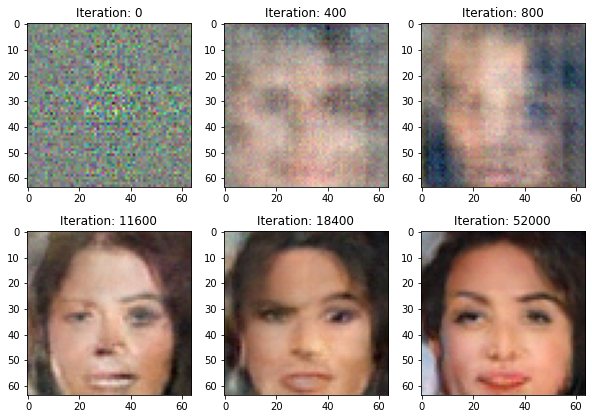

In [ ]:
vis_iters = [0, 400, 800, 11600, 18400, 52000]
fig = plt.figure(figsize=(10, 7))
row, col = 3, 2
for i in range(len(vis_iters)):
    _it = vis_iters[i]
    vis_img_pth = glob(f'./gen_images/{_it}.png')[0]
    vis_img = get_image(vis_img_pth, IMAGE_WIDTH, IMAGE_HEIGHT,
                      mode='RGB')
    plt.subplot(col, row, i+1)
    plt.title(f"Iteration: {_it}")
    plt.imshow(vis_img)


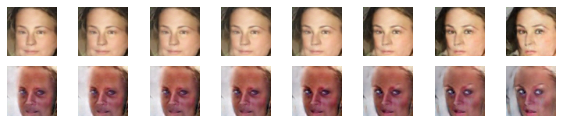

In [ ]:
np.random.seed(seed=1)
new_seeds = [np.random.normal(size=(1,z_dim)) for _ in range(2)]
fig = plt.figure(figsize=(10, 2))
row, col = 2, 8

for n, seed in enumerate(new_seeds):
    count = n * col
    for i in range(col):
        _s = seed
        _s[0][10] = _s[0][10] + 0.2 * i
        vis_img = G(_s, training=False)[0]
        tf.keras.preprocessing.image.save_img('./test.png', vis_img)
        vis_img = get_image('./test.png', IMAGE_WIDTH, IMAGE_HEIGHT,
                      mode='RGB')
        plt.subplot(row, col, count+i+1)
        plt.axis('off')
        plt.imshow(vis_img)